<a href="https://colab.research.google.com/github/SashaSBonacina/PET-Alzheimer-Prediction-Thesis/blob/main/BAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

## Importing libraries

In [9]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2, re, itertools,pathlib
from skimage import transform
import scipy.ndimage as ndi
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


## Mounting google drive to access the data

In [10]:
drive.mount('/content/drive') #mounting drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading in CSV with Image ID, Age, Sex

In [11]:
cols = ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit',
       'Description', 'Type', 'Acq Date'] # we dont need all the columns
df = pd.read_csv('/content/drive/MyDrive/CN FOR BAE DATA/Tx_Origin_SpatNORM_CN.csv', usecols = cols)
df.columns = ['ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit',
       'Descrip', 'Type', 'Acq Date'] # renaming cols


In [12]:
df.head()

,ID,Subject,Group,Sex,Age,Visit,Descrip,Type,Acq Date
0,I387827,024_S_4084,CN,F,71,v21,[F-18]AV-45 Dy2 4i/16s AV45,Original,8/27/2013
1,I388229,024_S_4158,CN,M,86,v21,[F-18]AV-45 Dy2 4i/16s AV45,Original,8/30/2013
2,I509380,024_S_4158,CN,M,88,v41,[F-18]AV-45 Dy1 4i/16s AV45,Original,9/03/2015
3,I388228,024_S_4158,CN,M,86,v21,[F-18]AV-45 Dy1 4i/1 Early AV45,Original,8/30/2013
4,I387826,024_S_4084,CN,F,71,v21,[F-18]AV-45 Dy1 4i/1 Early AV45,Original,8/27/2013


Collecting file paths with the images

In [13]:
directory = '/content/drive/MyDrive/CN FOR BAE DATA/Tx_Origin_SpatNORM_CN_imageID' # enter the dir were the images are stored
image_ids = []
for filename in os.listdir(directory):
  image_ids.append(filename)
print(len(image_ids))

102


In [14]:
df = df[df['ID'].isin(image_ids)] #filterring the df so it only contains the data we need
df = df.reset_index()

In [15]:
df.shape

(102, 10)

Adding the image paths to the df for the corresponding image ID

In [16]:
# new colunm for the paths
df['Loc'] = ''
# iterate over files in that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    image_id_folder = filename

    for image in os.listdir(f):
      f = os.path.join(f, image)
      if os.path.isfile(f) and f.endswith('nii'):  # checking if it is a file and a .nii file
          df.loc[df['ID']==image_id_folder, 'Loc' ] = f # appending the path

In [17]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'M' else -1)

# Data Information (vis)

## Bar graphs

In [ ]:
df['Shape'] = df['Loc'].apply(lambda x: nib.load(x).get_fdata().shape) # adding the shape of each image as a feature
df['Type'] = df['Loc'].apply(lambda x: type(nib.load(x))) # adding the type of each image as a feature

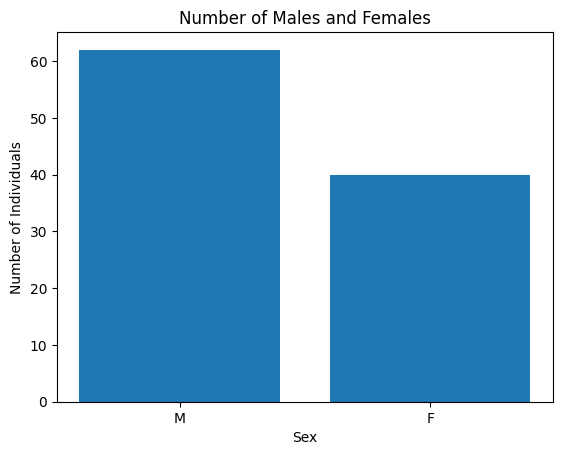

In [ ]:
sex_counts = df["Sex"].value_counts()
# Plot the bar chart
plt.bar(sex_counts.index, sex_counts.values)
plt.xlabel("Sex")
plt.ylabel("Number of Individuals")
plt.title("Number of Males and Females")
plt.show()

Text(0.5, 1.0, 'Age Distribution')

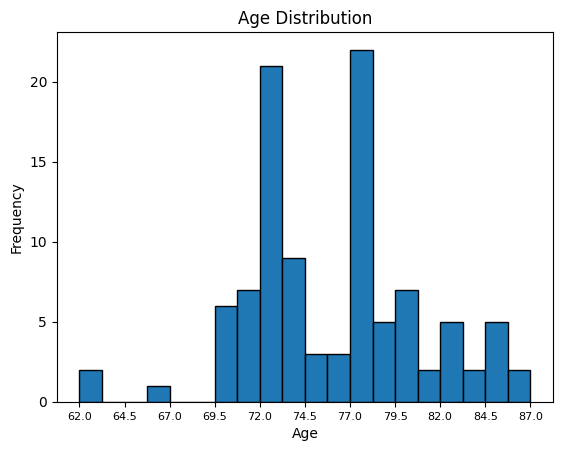

In [ ]:
plt.hist(df["Age"], bins=20, edgecolor="black")
plt.xlabel("Age")
plt.ylabel("Frequency")
num_ticks = 11  # The number of ticks you want
x_ticks = np.linspace(df["Age"].min(), df["Age"].max(), num_ticks)
plt.xticks(x_ticks, fontsize=8)

plt.title("Age Distribution")

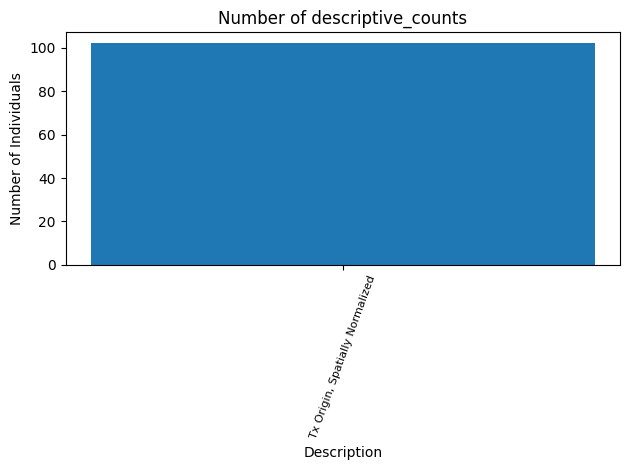

In [ ]:
descriptive_counts = df["Descrip"].value_counts()
# Plot the bar chart
plt.bar(descriptive_counts.index, descriptive_counts.values)
plt.xlabel("Description")
plt.ylabel("Number of Individuals")
plt.title("Number of descriptive_counts")
plt.xticks(fontsize=8, rotation=70)
plt.tight_layout()
plt.show()

In [ ]:
len(df['Subject'].unique())

102

Each subject has only 1 image in the df

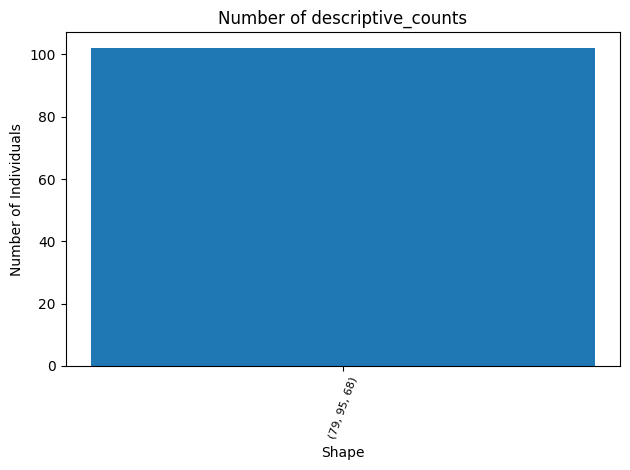

In [ ]:
descriptive_counts = df["Shape"].astype(str).value_counts()

# Plot the bar chart
plt.bar(descriptive_counts.index, descriptive_counts.values)
plt.xlabel("Shape")
plt.ylabel("Number of Individuals")
plt.title("Number of descriptive_counts")
plt.xticks(fontsize=8, rotation=70)
plt.tight_layout()
plt.show()

No reshaping needed as all are the same shape! This is because the same processing steps were taken by ADNI for each image.

Furthermore each image is 3d not 4d, so t has been average through the image in processing

## Looking at one image

In [ ]:
x = list(df['Loc'])[6] # getting a random image path
brain_vol = nib.load(x)
# What is the type of this object?
type(brain_vol)

nibabel.nifti1.Nifti1Image

In [ ]:
brain_vol_data = brain_vol.get_fdata()
type(brain_vol_data)

numpy.memmap

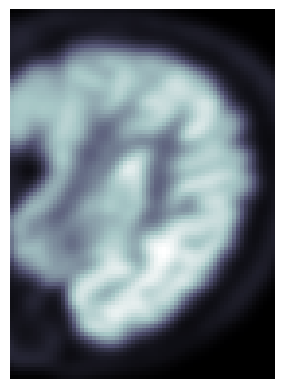

In [ ]:
plt.imshow(brain_vol_data[60], cmap='bone')
plt.axis('off')
plt.show()

# Building some models!

## 3D model

### preparing the data

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
import keras


Extracting data in the correct format for the model

In [19]:
# Extract image data and corresponding ages from the DataFrame
image_paths = df['Loc'].values
ages = df['Age'].values
sexes = df['Sex'].values

# Initialize empty lists to store image arrays and labels
image_data = []
labels = []

# Loop through each image path, load the image, and append to the lists
for path, age in zip(image_paths, ages):
    image = nib.load(path).get_fdata()
    image_data.append(image)
    labels.append(age)

# Convert lists to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Reshape the image data to match the CNN input shape (128, 128, 82, 6) -> (samples, 128, 128, 82, 6)
image_data = image_data.reshape(-1, 79, 95, 68, 1)



In [20]:
from numpy.random import seed
seed(1)
# Set the random seed
tf.random.set_seed(42)

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data, train_sex, test_sex, train_labels, test_labels = train_test_split(image_data, sexes, ages, test_size=0.2, random_state=42)

### Baseline
the baseline will be the average of the ages

In [ ]:
mean_age = np.mean(ages)

In [ ]:
predictions = np.ones(len(test_labels))*mean_age

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 20.140921074312082
Mean Absolute Error: 3.710084033613445
R-squared: -0.03521517409925745


### v1
model without sex, without transfer learning, ...

In [ ]:
model = Sequential() # using sequential

# Add 3D Convolutional layers with MaxPooling
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(79, 95, 68, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(79, 95, 68, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


# Flatten the output and add Dense layers for age prediction
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression tasks

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 77, 93, 66, 64)    1792      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 38, 46, 33, 64)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 36, 44, 31, 64)    110656    
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 18, 22, 15, 64)   0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 380160)            0         
                                                                 
 dense_2 (Dense)             (None, 32)               

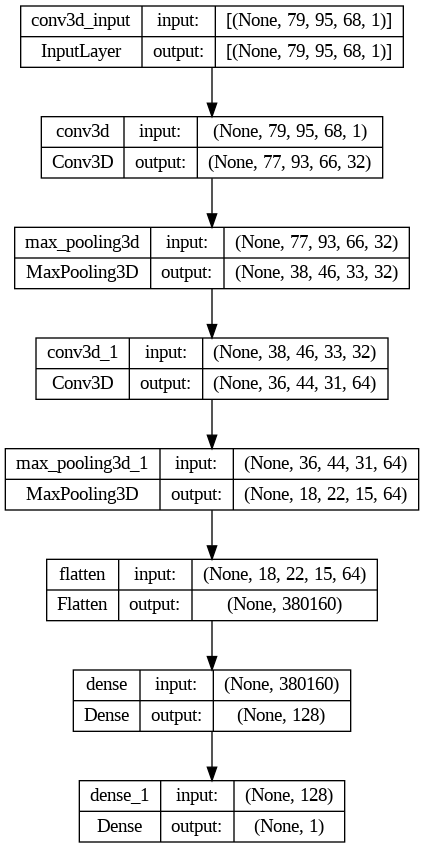

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True) #vis of architecture


Lets train the model

Epoch 1/100
4/4 [==============================] - 7s 630ms/step - loss: 1603.3151 - val_loss: 558.3917
Epoch 2/100
4/4 [==============================] - 2s 515ms/step - loss: 242.6407 - val_loss: 17.4587
Epoch 3/100
4/4 [==============================] - 2s 512ms/step - loss: 81.2380 - val_loss: 73.1248
Epoch 4/100
4/4 [==============================] - 2s 512ms/step - loss: 67.7747 - val_loss: 37.3367
Epoch 5/100
4/4 [==============================] - 2s 515ms/step - loss: 55.3452 - val_loss: 17.3344
Epoch 6/100
4/4 [==============================] - 2s 513ms/step - loss: 39.8516 - val_loss: 24.4594
Epoch 7/100
4/4 [==============================] - 2s 514ms/step - loss: 43.3930 - val_loss: 41.6462
Epoch 8/100
4/4 [==============================] - 2s 513ms/step - loss: 45.4916 - val_loss: 20.5834
Epoch 9/100
4/4 [==============================] - 2s 515ms/step - loss: 35.8730 - val_loss: 16.2863
Epoch 10/100
4/4 [==============================] - 2s 511ms/step - loss: 36.7894 - val

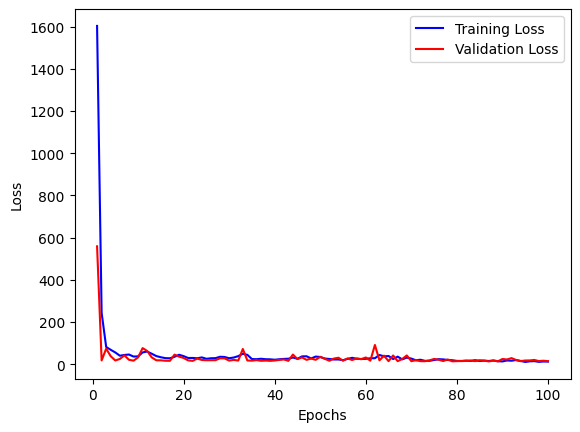

In [ ]:
# Run model.fit() and store the training history
history = model.fit(train_data, train_labels, epochs=100, batch_size=16, validation_split=0.2)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Zoom in on the graph

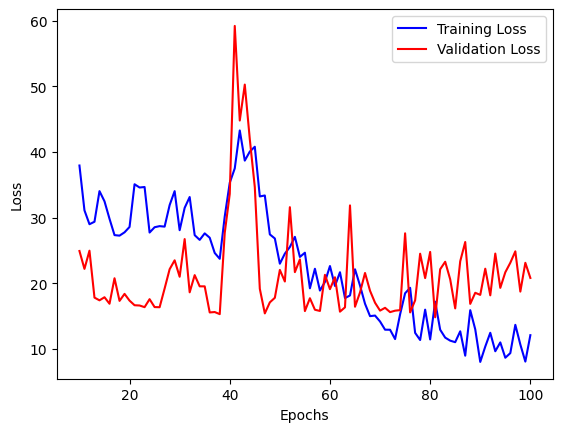

In [ ]:
epochs = range(10, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss[9:], 'b', label='Training Loss')
plt.plot(epochs, val_loss[9:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We see that the model is unstable and over fits for high epochs

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)


1/1 [==============================] - 1s 1s/step - loss: 21.2501
Test Loss: 21.250104904174805


In [ ]:
predictions = model.predict(test_data)
# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

1/1 [==============================] - 0s 122ms/step
Mean Squared Error: 21.250103735891614
Mean Absolute Error: 3.9014187767392112
R-squared: -0.09222561160002374


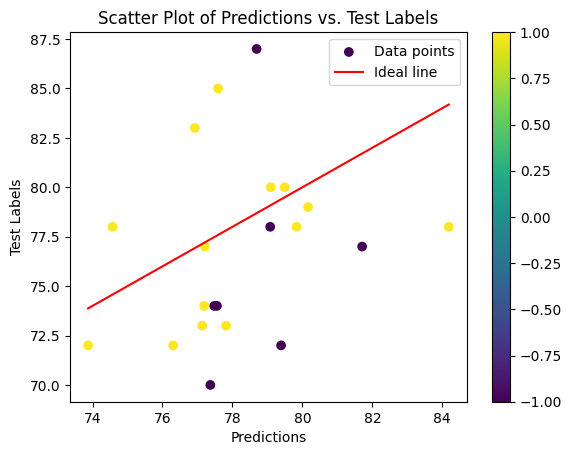

In [ ]:
# Assuming you have your data for predictions, test_labels, and sex_train
# Create a scatter plot
plt.scatter(predictions, test_labels, c=test_sex, cmap='viridis', label='Data points')
plt.plot([min(predictions), max(predictions)], [min(predictions), max(predictions)], c='red', label='Ideal line')

# Add labels and title
plt.xlabel('Predictions')
plt.ylabel('Test Labels')
plt.title('Scatter Plot of Predictions vs. Test Labels')

# Add a legend
plt.legend()

# Show the plot
plt.colorbar()  # Add a colorbar to show the mapping of colors to sex_train values
plt.show()



We see more males (1) above the line and females below, perhaps adding sex as a feature can improve the model? This will be done later

### v2
Adding early stopping to prevent overfitting

In [ ]:
model = Sequential() # using sequential

# Add 3D Convolutional layers with MaxPooling
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(79, 95, 68, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output and add Dense layers for age prediction
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression tasks

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

Lets train the model with early stopping

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=100),
             ModelCheckpoint(filepath='basic_model.h5', monitor='val_loss', save_best_only=True)]

Epoch 1/200
4/4 [==============================] - 4s 935ms/step - loss: 1874.2095 - val_loss: 105.7820
Epoch 2/200
4/4 [==============================] - 3s 881ms/step - loss: 109.7326 - val_loss: 48.4341
Epoch 3/200
4/4 [==============================] - 1s 322ms/step - loss: 92.6586 - val_loss: 102.2901
Epoch 4/200
4/4 [==============================] - 1s 320ms/step - loss: 69.5794 - val_loss: 76.3067
Epoch 5/200
4/4 [==============================] - 1s 322ms/step - loss: 51.5871 - val_loss: 83.2177
Epoch 6/200
4/4 [==============================] - 1s 320ms/step - loss: 50.0983 - val_loss: 55.4376
Epoch 7/200
4/4 [==============================] - 4s 1s/step - loss: 42.7931 - val_loss: 47.8488
Epoch 8/200
4/4 [==============================] - 3s 907ms/step - loss: 48.1486 - val_loss: 21.0376
Epoch 9/200
4/4 [==============================] - 1s 321ms/step - loss: 26.2786 - val_loss: 28.5089
Epoch 10/200
4/4 [==============================] - 1s 322ms/step - loss: 28.7991 - val_l

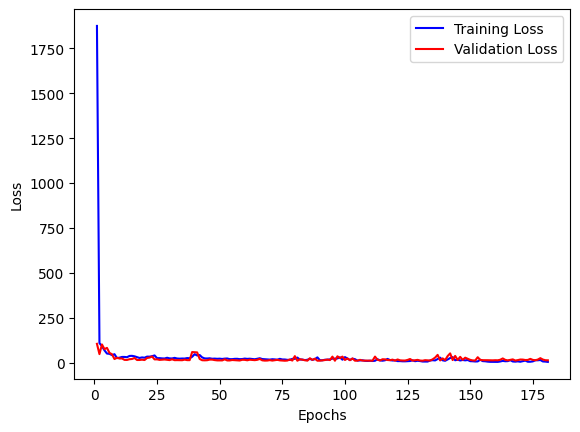

In [ ]:
# Run model.fit() and store the training history
history = model.fit(train_data, train_labels, epochs=200, batch_size=16, validation_split=0.2, callbacks = callbacks)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Zoom in on the graph

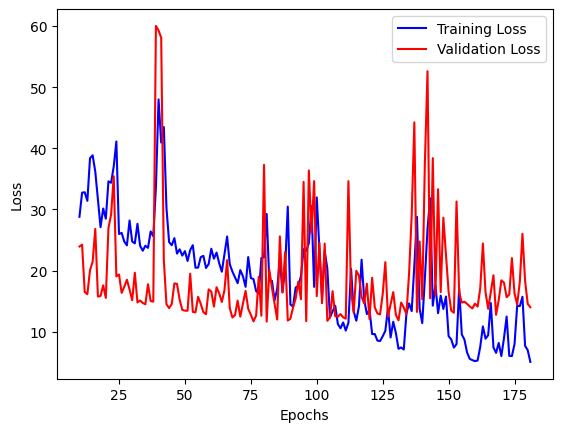

In [ ]:
epochs = range(10, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss[9:], 'b', label='Training Loss')
plt.plot(epochs, val_loss[9:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We see that the model begins to over fit for high epochs and this is where the early stopping stops the models from training

In [ ]:
from keras.models import load_model
saved_model = load_model('basic_model.h5')
train_acc = saved_model.evaluate(train_data, train_labels, verbose=0)
test_acc = saved_model.evaluate(test_data, test_labels, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 14.208, Test: 17.417


In [ ]:
# Evaluate the model on the test set
test_loss = saved_model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)


1/1 [==============================] - 0s 152ms/step - loss: 17.4171
Test Loss: 17.417123794555664


In [ ]:
predictions = saved_model.predict(test_data)
# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

1/1 [==============================] - 0s 93ms/step
Mean Squared Error: 17.417124618923047
Mean Absolute Error: 3.4120225452241444
R-squared: 0.10478415420220688


The model has improved a very small amount

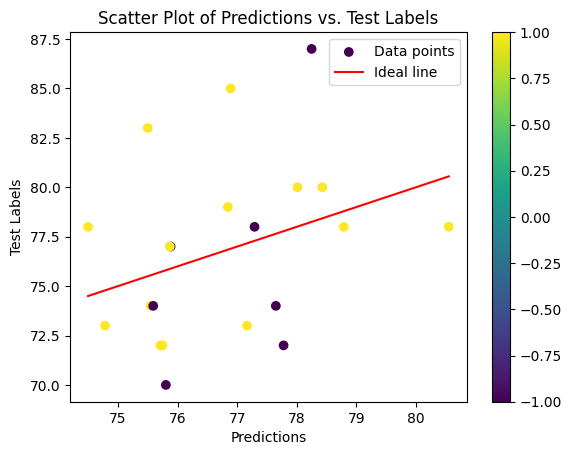

In [ ]:
# Assuming you have your data for predictions, test_labels, and sex_train
# Create a scatter plot
plt.scatter(predictions, test_labels, c=test_sex, cmap='viridis', label='Data points')
plt.plot([min(predictions), max(predictions)], [min(predictions), max(predictions)], c='red', label='Ideal line')

# Add labels and title
plt.xlabel('Predictions')
plt.ylabel('Test Labels')
plt.title('Scatter Plot of Predictions vs. Test Labels')

# Add a legend
plt.legend()

# Show the plot
plt.colorbar()  # Add a colorbar to show the mapping of colors to sex_train values
plt.show()



Somehow sex is now more scattered, we can still try adding it as a feature to see if it helps


###  V3
Adding sex as a feature with early stopping

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, concatenate

# Define the input layer for the 3D Convolutional network
input_img = Input(shape=(79, 95, 68, 1))

# Apply 3D Convolutional layers with MaxPooling using the Functional API
x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu')(input_img)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)

# Flatten the output and add Dense layers for age prediction
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_img = Dense(1, activation='linear')(x)

# Define the input layer for the extra feature
input_extra = Input(shape=(1,))

# Concatenate the output of the Convolutional network with the extra feature
merged = concatenate([output_img, input_extra])

# Add Dense layers for further prediction
merged = Dense(4, activation='relu')(merged)
output = Dense(1, activation='linear')(merged)  # Use 'linear' activation for regression tasks

# Define the model with both inputs and the final output
model = Model(inputs=[input_img, input_extra], outputs=output)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


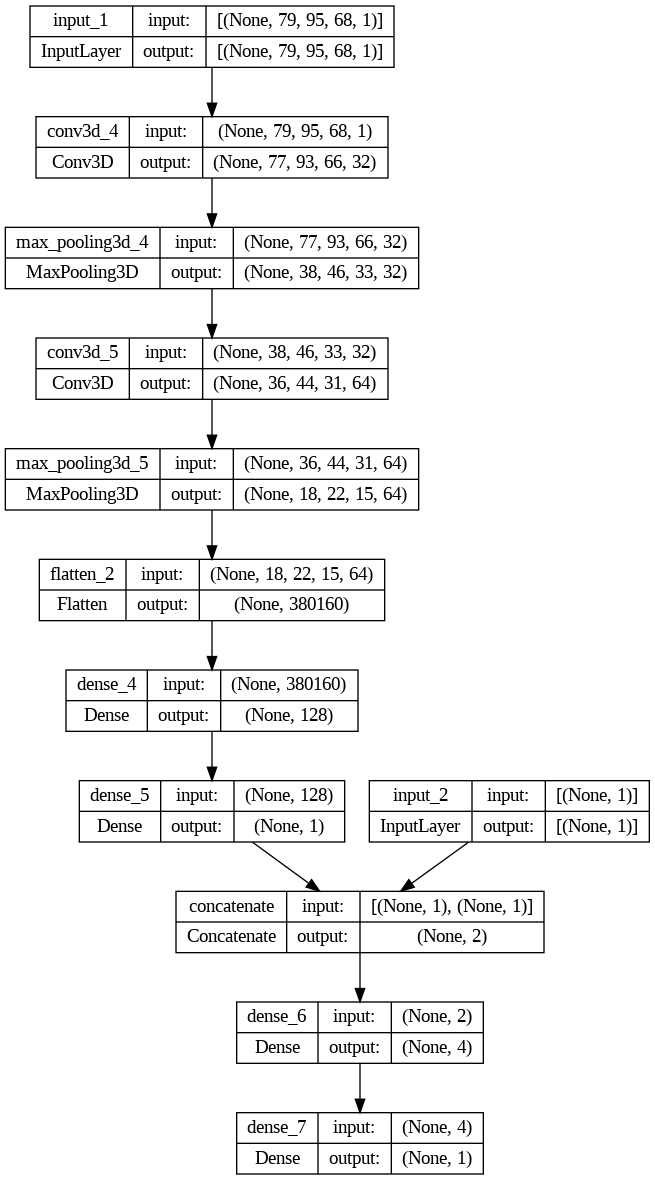

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True) #vis of architecture

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=100),
             ModelCheckpoint(filepath='basic_sex_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
# Run model.fit() and store the training history
history = model.fit([train_data, train_sex], train_labels, epochs=200, batch_size=16, validation_split=0.2, callbacks = callbacks)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/200
4/4 [==============================] - 7s 973ms/step - loss: 1876.6921 - val_loss: 244.4738
Epoch 2/200
4/4 [==============================] - 5s 2s/step - loss: 179.5693 - val_loss: 77.4480
Epoch 3/200
4/4 [==============================] - 5s 2s/step - loss: 70.9750 - val_loss: 19.2902
Epoch 4/200
4/4 [==============================] - 1s 326ms/step - loss: 39.9257 - val_loss: 37.1825
Epoch 5/200
4/4 [==============================] - 1s 335ms/step - loss: 51.8539 - val_loss: 36.5482
Epoch 6/200
4/4 [==============================] - 1s 326ms/step - loss: 39.8069 - val_loss: 23.4252
Epoch 7/200
4/4 [==============================] - 1s 328ms/step - loss: 38.5167 - val_loss: 23.0626
Epoch 8/200
4/4 [==============================] - 1s 332ms/step - loss: 39.7592 - val_loss: 36.3376
Epoch 9/200
4/4 [==============================] - 1s 329ms/step - loss: 40.7678 - val_loss: 27.9268
Epoch 10/200
4/4 [==============================] - 3s 959ms/step - loss: 37.3784 - val_loss:

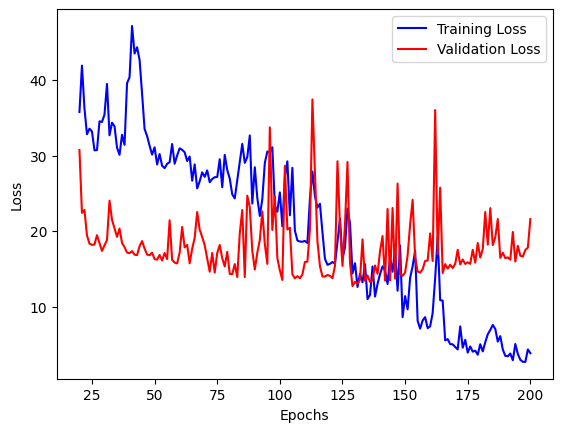

In [ ]:
epochs = range(20, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss[19:], 'b', label='Training Loss')
plt.plot(epochs, val_loss[19:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
saved_model = load_model('basic_sex_model.h5')
train_acc = saved_model.evaluate([train_data, train_sex], train_labels, verbose=0)
test_acc = saved_model.evaluate([test_data, test_sex], test_labels, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 10.361, Test: 19.620


In [ ]:
predictions = saved_model.predict([test_data, test_sex])
# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

1/1 [==============================] - 0s 114ms/step
Mean Squared Error: 21.4392309407565
Mean Absolute Error: 3.599167960030692
R-squared: -0.10194648541650553


The model has improved slightly

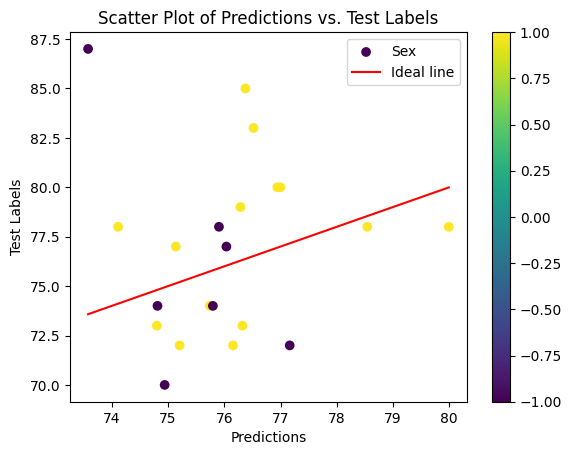

In [ ]:
# Assuming you have your data for predictions, test_labels, and sex_train
# Create a scatter plot
plt.scatter(predictions, test_labels, c=test_sex, cmap='viridis', label='Sex')
plt.plot([min(predictions), max(predictions)], [min(predictions), max(predictions)], c='red', label='Ideal line')

# Add labels and title
plt.xlabel('Predictions')
plt.ylabel('Test Labels')
plt.title('Scatter Plot of Predictions vs. Test Labels')

# Add a legend
plt.legend()

# Show the plot
plt.colorbar()  # Add a colorbar to show the mapping of colors to sex_train values
plt.show()



We see that after adding sex the poins are more equally spread however the model still does not perform too well, perhaps tuning the model will help

### V4
Tuning the model with bayesian optimisation, this is more effecient than grid and random search (typically)

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
import time
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam

def create_model(kernel_size, num_layers, neurons1, neurons2 = 32, neurons3 =32, learning_rate=0.001, dilation_rate=(1,1,1), pool_size = (2,2,2), activation = 'relu', strides=(1,1,1), padding='same'):
  # Define the input layer for the 3D Convolutional network
  input_img = Input(shape=(79, 95, 68, 1))
  x = Conv3D(neurons1, kernel_size=kernel_size, activation=activation)(input_img)
  x = MaxPooling3D(pool_size=pool_size)(x)
  # Apply 3D Convolutional layers with MaxPooling using the Functional API
  for i in range(num_layers):
    x = Conv3D(neurons1, kernel_size=kernel_size, activation=activation)(x)
    x = MaxPooling3D(pool_size=pool_size)(x)
  # Flatten the output and add Dense layers for age prediction
  x = Flatten()(x)
  x = Dense(neurons2, activation=activation)(x)
  output_img = Dense(1, activation='linear')(x)
  # Define the input layer for the extra feature
  input_extra = Input(shape=(1,))
  # Concatenate the output of the Convolutional network with the extra feature
  merged = concatenate([output_img, input_extra])
  # Add Dense layers for further prediction
  merged = Dense(neurons3, activation=activation)(merged)
  output = Dense(1, activation='linear')(merged)  # Use 'linear' activation for regression tasks
  # Define the model with both inputs and the final output
  model = Model(inputs=[input_img, input_extra], outputs=output)
  optimizer = Adam(learning_rate=learning_rate)
  # Compile the model
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model


def objective(trial):
    """return the mse"""
    num_layers = trial.suggest_int('num_layers', low = 1, high = 2, step = 1)
    kernel_size = trial.suggest_categorical('kernel_size', [(3,3,3), (5,5,5)])
    neurons1 = trial.suggest_int('neurons1', low = 32, high = 64, step = 1)


    # random forest classifier object
    model = create_model(kernel_size = kernel_size, num_layers = num_layers, neurons1 = neurons1)

    model.fit([train_data, train_sex], train_labels, epochs=10, batch_size= 32, validation_split=0.2)

    return(model.evaluate([test_data, test_sex], test_labels, verbose=0))

# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='minimize')

# perform hyperparamter tuning (while timing the process)
time_start = time.time()
study.optimize(objective, n_trials=10)
time_bayesian = time.time() - time_start

columns = ['Number of iterations', 'Iteration Number of Optimal Hyperparamters', 'Score', 'Time Elapsed (s)']

# store result in a data frame
values_bayesian = [100, study.best_trial.number, study.best_trial.value, time_bayesian]
results_bayesian = pd.DataFrame([values_bayesian], columns = columns)

[I 2023-08-14 13:55:07,401] A new study created in memory with name: no-name-7c833133-733c-4b39-99a1-a2941ffa1cd8


Epoch 1/10


[W 2023-08-14 13:55:29,488] Trial 0 failed with parameters: {'num_layers': 1, 'kernel_size': (5, 5, 5), 'neurons1': 44} because of the following error: ResourceExhaustedError().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-20-5ee91aa49241>", line 45, in objective
    model.fit([train_data, train_sex], train_labels, epochs=10, batch_size= 32, validation_split=0.2)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_3/max_pooling3d_11

ResourceExhaustedError: ignored

In [ ]:
from keras.optimizers import Adam
from keras.models import load_model

def create_model(kernel_size, num_layers, neurons1, neurons2, neurons3, learning_rate, dilation_rate, pool_size = (2,2,2), activation = 'relu', strides=(1,1,1), padding='same'):
  # Define the input layer for the 3D Convolutional network
  input_img = Input(shape=(79, 95, 68, 1))
  x = Conv3D(neurons1, kernel_size=kernel_size, activation=activation)(input_img)
  x = MaxPooling3D(pool_size=pool_size)(x)
  # Apply 3D Convolutional layers with MaxPooling using the Functional API
  for i in range(num_layers):
    x = Conv3D(neurons1, kernel_size=kernel_size, activation=activation)(x)
    x = MaxPooling3D(pool_size=pool_size)(x)
  # Flatten the output and add Dense layers for age prediction
  x = Flatten()(x)
  x = Dense(neurons2, activation=activation)(x)
  output_img = Dense(1, activation='linear')(x)
  # Define the input layer for the extra feature
  input_extra = Input(shape=(1,))
  # Concatenate the output of the Convolutional network with the extra feature
  merged = concatenate([output_img, input_extra])
  # Add Dense layers for further prediction
  merged = Dense(neurons3, activation=activation)(merged)
  output = Dense(1, activation='linear')(merged)  # Use 'linear' activation for regression tasks
  # Define the model with both inputs and the final output
  model = Model(inputs=[input_img, input_extra], outputs=output)
  optimizer = Adam(learning_rate=learning_rate)
  # Compile the model
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model


In [ ]:
param_grid = {
    'num_layers': [1,2],         # Number of filters in convolutional layers
    'kernel_size': [(3, 3, 3), (5, 5, 5)],   # Kernel size for convolutional layers
    'dilation_rate': [(1,1,1)], # Dilation rate for dilated convolutions
    'neurons1': [32, 64],        # Number of neurons in the Dense layer
    'neurons2': [32,64],        # Number of neurons in the Dense layer
    'neurons3': [32, 64],        # Number of neurons in the Dense layer
    'learning_rate': [0.001, 0.01, 0.0001],   # Learning rate for optimizer
    'batch_size': [8,16],           # Batch size for training
}


In [ ]:
param_grid = {
    'num_layers': [1],         # Number of filters in convolutional layers
    'kernel_size': [(3, 3, 3)],   # Kernel size for convolutional layers
    'dilation_rate': [(1,1,1)], # Dilation rate for dilated convolutions
    'neurons1': [32],        # Number of neurons in the Dense layer
    'neurons2': [32],        # Number of neurons in the Dense layer
    'neurons3': [32],        # Number of neurons in the Dense layer
    'learning_rate': [0.001],   # Learning rate for optimizer
    'batch_size': [16],           # Batch size for training
}

In [ ]:
import random
random.seed(40)

# Set the number of random samples you want to generate
num_samples = 10
samples = []
for _ in range(num_samples):
  dic_sample = {}
  for key in param_grid.keys():
    dic_sample[key] = random.sample(param_grid[key],1)[0]
  samples.append(dic_sample)

print(samples)




[{'num_layers': 2, 'kernel_size': (3, 3, 3), 'dilation_rate': (1, 1, 1), 'neurons1': 64, 'neurons2': 32, 'neurons3': 32, 'learning_rate': 0.01, 'batch_size': 16}, {'num_layers': 2, 'kernel_size': (3, 3, 3), 'dilation_rate': (1, 1, 1), 'neurons1': 32, 'neurons2': 32, 'neurons3': 64, 'learning_rate': 0.001, 'batch_size': 8}, {'num_layers': 2, 'kernel_size': (3, 3, 3), 'dilation_rate': (1, 1, 1), 'neurons1': 64, 'neurons2': 32, 'neurons3': 32, 'learning_rate': 0.01, 'batch_size': 8}, {'num_layers': 2, 'kernel_size': (5, 5, 5), 'dilation_rate': (1, 1, 1), 'neurons1': 32, 'neurons2': 64, 'neurons3': 32, 'learning_rate': 0.0001, 'batch_size': 16}, {'num_layers': 2, 'kernel_size': (5, 5, 5), 'dilation_rate': (1, 1, 1), 'neurons1': 32, 'neurons2': 64, 'neurons3': 64, 'learning_rate': 0.0001, 'batch_size': 8}, {'num_layers': 1, 'kernel_size': (3, 3, 3), 'dilation_rate': (1, 1, 1), 'neurons1': 32, 'neurons2': 64, 'neurons3': 64, 'learning_rate': 0.001, 'batch_size': 8}, {'num_layers': 1, 'kernel

In [ ]:
import gc
results = {}
for i, sample in enumerate(samples):
  print(f'{i+1} iteration')
  print('New sample of parameters')
  callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='basic.h5', monitor='val_loss', save_best_only=True)]
  model = create_model(kernel_size = sample['kernel_size'], num_layers = sample['num_layers'], neurons1 = sample['neurons1'], neurons2=sample['neurons2'], neurons3=sample['neurons3'], learning_rate=sample['learning_rate'], dilation_rate=sample['dilation_rate'])
  model.fit([train_data, train_sex], train_labels, epochs=10, batch_size= sample['batch_size'], validation_split=0.2)

  # Do some code, e.g. train and save model
  tf.keras.backend.clear_session()
  saved_model = load_model('basic.h5')
  print('Appending results')
  results[f'{sample}'] = saved_model.evaluate([test_data, test_sex], test_labels, verbose=0)

  del model
  tf.keras.backend.clear_session()
  tf.compat.v1.reset_default_graph()
  gc.collect()


1 iteration
New sample of parameters
Epoch 1/10
4/4 [==============================] - 3s 617ms/step - loss: 16311.7256 - val_loss: 3628.3477
Epoch 2/10
4/4 [==============================] - 2s 532ms/step - loss: 2272.5059 - val_loss: 3244.3381
Epoch 3/10
4/4 [==============================] - 2s 529ms/step - loss: 3852.5757 - val_loss: 5942.6006
Epoch 4/10
4/4 [==============================] - 2s 533ms/step - loss: 6264.8433 - val_loss: 5764.7944
Epoch 5/10
4/4 [==============================] - 2s 533ms/step - loss: 5668.1221 - val_loss: 5148.0288
Epoch 6/10
4/4 [==============================] - 2s 531ms/step - loss: 2901.5920 - val_loss: 3876.4797
Epoch 7/10
4/4 [==============================] - 2s 533ms/step - loss: 1913.7345 - val_loss: 2185.6965
Epoch 8/10
4/4 [==============================] - 2s 534ms/step - loss: 1132.3748 - val_loss: 106.8403
Epoch 9/10
4/4 [==============================] - 2s 537ms/step - loss: 366.7131 - val_loss: 25.8892
Epoch 10/10
4/4 [=============

OSError: ignored

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
pip install classification-models-3D

In [ ]:
pip install keras_applications

In [ ]:
from classification_models_3D.tfkeras import Classifiers

vgg19, preprocess_input = Classifiers.get('vgg19')
pretrained_model = vgg19(input_shape=(128, 128, 128, 3), weights='imagenet')

In [ ]:
keras.utils.plot_model(pretrained_model, "multi_input_and_output_model.png", show_shapes=True)


In [ ]:

# Initialize empty lists to store image arrays and labels
image_data = []
labels = []

# Loop through each image path, load the image, and append to the lists
for path, age in zip(image_paths, ages):
    image = nib.load(path).get_fdata()
    image_data.append(image)
    labels.append(age)

# Convert lists to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)


image_data_padded = []

for img in image_data:
  target_shape = (128, 128, 128)

  # Calculate the padding amounts for each dimension
  pad_widths = [(0, target_shape[i] - img.shape[i]) for i in range(3)]

  # Pad the array with zeros to match the target shape
  padded_array = np.pad(img, pad_widths, mode='constant')

  image_data_padded.append([padded_array,padded_array,padded_array])

image_data_padded = np.array(image_data_padded)


# Reshape the image data to match the CNN input shape (128, 128, 82, 6) -> (samples, 128, 128, 82, 6)
image_data = image_data_padded.reshape(-1, 128,128,128,3)



In [ ]:
image_data.shape

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(image_data, ages, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()

for layer in pretrained_model.layers:
    model.add(layer)

# Freeze the weights of the pre-trained layers so they are not updated during training
for layer in model.layers:
    layer.trainable = False

# Flatten the output and add Dense layers for age prediction
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression tasks



# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
import matplotlib.pyplot as plt

# Run model.fit() and store the training history
history = model.fit(train_data, train_labels, epochs=50, batch_size=8, validation_split=0.2)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# The model does not outperform the baseline

 There are many things that can be changed:

- Adding sex as a feature
- Transfer Learning
- Dilated convolutions
- Random & Grid search to tune model
- Encorporating other metrics such as avg age
- Using 2d slices instead using GLOM for slice selection